In [ ]:
!pip install datasets
!pip install transformers
!pip install onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 432 kB 27.8 MB/s 
     |████████████████████████████████| 163 kB 68.4 MB/s 
     |████████████████████████████████| 115 kB 74.0 MB/s 
     |████████████████████████████████| 212 kB 75.2 MB/s 
     |████████████████████████████████| 127 kB 73.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 10.5 MB/s 
     |████████████████████████████████| 6.6 MB 51.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 14.7 MB/s 
     |████████████████████████████████| 46 kB 2.1 MB/s 
     |██████████████████

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import torch

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false" # to avoid a warning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Split the data into train and test sets
split = 0.1
df = pd.read_csv('/content/drive/MyDrive/electronics_small.csv')

df = df[['reviewText', 'overall']].rename(columns={'reviewText': 'text', 'overall': 'label'})
df['label'] = df['label'].astype(float)
df = df.dropna()

# df['label'] = df['label'].apply(lambda x: x-1)

# only select first 100 rows for testing
df = df[:50000]

df_train, df_test = train_test_split(df, test_size=split, random_state=1)

df_train.to_csv('electronics_train.csv', index=False)
df_test.to_csv('electronics_test.csv', index=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


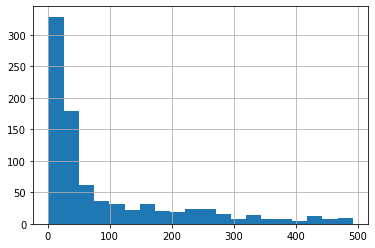

In [ ]:
df['length'] = df["text"].apply(len)
df[df['length']<500]['length'].hist(bins=20)

In [ ]:
# Load the data into the datasets library
train_dataset = load_dataset('csv', data_files='electronics_train.csv')['train']
test_dataset = load_dataset('csv', data_files='electronics_test.csv')['train']

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-c7d2e36ff89a40b4/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-22dc2a5d29ddd7e4/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8d54c1c3-9fb9-489a-a842-df3af015de86)


In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256, return_tensors="pt").to(device)
 
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

  0%|          | 0/45 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1).to(device)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

In [ ]:
from sklearn.metrics import mean_squared_error

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    rmse = mean_squared_error(labels, predictions, squared=False)
    return {"rmse": rmse}

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [ ]:
from transformers import TrainingArguments, Trainer
 
repo_name = "amazon-review-sentiment-analysis_large"
 
training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=64,
   per_device_eval_batch_size=64,
   num_train_epochs=10,
   weight_decay=0.01,
   save_strategy="epoch",
   push_to_hub=True,
)
 
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/Christian2903/amazon-review-sentiment-analysis_large into local empty directory.


In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 45000
  Num Epochs = 10
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 7040
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text foll

Step,Training Loss
500,1.142100
1000,0.418900
1500,0.348900
2000,0.286500
2500,0.247000
3000,0.224700
3500,0.202100
4000,0.181200
4500,0.165800
5000,0.158600


Saving model checkpoint to amazon-review-sentiment-analysis_large/checkpoint-704
Configuration saved in amazon-review-sentiment-analysis_large/checkpoint-704/config.json
Model weights saved in amazon-review-sentiment-analysis_large/checkpoint-704/pytorch_model.bin
tokenizer config file saved in amazon-review-sentiment-analysis_large/checkpoint-704/tokenizer_config.json
Special tokens file saved in amazon-review-sentiment-analysis_large/checkpoint-704/special_tokens_map.json
tokenizer config file saved in amazon-review-sentiment-analysis_large/tokenizer_config.json
Special tokens file saved in amazon-review-sentiment-analysis_large/special_tokens_map.json
Saving model checkpoint to amazon-review-sentiment-analysis_large/checkpoint-1408
Configuration saved in amazon-review-sentiment-analysis_large/checkpoint-1408/config.json
Model weights saved in amazon-review-sentiment-analysis_large/checkpoint-1408/pytorch_model.bin
tokenizer config file saved in amazon-review-sentiment-analysis_large

TrainOutput(global_step=7040, training_loss=0.2798132649199529, metrics={'train_runtime': 9247.8454, 'train_samples_per_second': 48.66, 'train_steps_per_second': 0.761, 'total_flos': 2.98046331648e+16, 'train_loss': 0.2798132649199529, 'epoch': 10.0})

In [ ]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 64


{'eval_loss': 0.3673693835735321,
 'eval_rmse': 0.6061100363731384,
 'eval_runtime': 40.2553,
 'eval_samples_per_second': 124.207,
 'eval_steps_per_second': 1.962,
 'epoch': 10.0}

In [ ]:
trainer.push_to_hub()

Saving model checkpoint to amazon-review-sentiment-analysis_large
Configuration saved in amazon-review-sentiment-analysis_large/config.json
Model weights saved in amazon-review-sentiment-analysis_large/pytorch_model.bin
tokenizer config file saved in amazon-review-sentiment-analysis_large/tokenizer_config.json
Special tokens file saved in amazon-review-sentiment-analysis_large/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/255M [00:00<?, ?B/s]

Upload file runs/Oct10_07-56-18_e53802179be1/events.out.tfevents.1665388586.e53802179be1.68.0:  55%|#####4    …

Upload file runs/Oct10_07-56-18_e53802179be1/events.out.tfevents.1665397875.e53802179be1.68.2: 100%|##########…

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Christian2903/amazon-review-sentiment-analysis_large
   ea7bc8d..6d81118  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Christian2903/amazon-review-sentiment-analysis_large
   ea7bc8d..6d81118  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}}
To https://huggingface.co/Christian2903/amazon-review-sentiment-analysis_large
   6d81118..228dee0  main -> main

   6d81118..228dee0  main -> main



'https://huggingface.co/Christian2903/amazon-review-sentiment-analysis_large/commit/6d811182f5b80cbe7b1438b6a7b07adeb82b8ed6'

In [ ]:
!python -m transformers.onnx --model={repo_name} --feature=sequence-classification onnx/

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
Moving 0 files to the new cache system
0it [00:00, ?it/s]
Local PyTorch model found.
Framework not requested. Using torch to export to ONNX.
Using framework PyTorch: 1.12.1+cu113
/usr/local/lib/python3.7/dist-packages/transformers/models/distilbert/modeling_distilbert.py:219: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  mask, torch.tensor(torch.finfo(scores.dtype).min)
Validating ONNX model...
	-[✓] ONNX model output names match reference model ({'logits'})
	- Validating ONNX Model output "logits":
		-[

In [ ]:
from transformers import AutoTokenizer
from onnxruntime import InferenceSession

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
session = InferenceSession("onnx/model.onnx")
# ONNX Runtime expects NumPy arrays as input
# inputs = tokenizer("Using DistilBERT with ONNX Runtime!", return_tensors="np")
# outputs = session.run(output_names=["logits"], input_feed=dict(inputs))
# outputs

reviews = ["This is a shit product", "This is a great product"]*500
batch_size = 32

import numpy as np
from tqdm import tqdm

predictions = []
for i in tqdm(range(0, len(reviews), batch_size)):
    batch = reviews[i:i+batch_size]
    inputs = tokenizer(batch, return_tensors="np", padding=True)
    outputs = session.run(output_names=["logits"], input_feed=dict(inputs))
    logits = outputs[0]
    predictions.extend(logits)

predictions

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.22.2",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

[array([1.2325011], dtype=float32),
 array([4.9371843], dtype=float32),
 array([1.2325011], dtype=float32),
 array([4.9371843], dtype=float32),
 array([1.2325011], dtype=float32),
 array([4.9371843], dtype=float32),
 array([1.2325011], dtype=float32),
 array([4.9371843], dtype=float32),
 array([1.2325011], dtype=float32),
 array([4.9371843], dtype=float32),
 array([1.2325011], dtype=float32),
 array([4.9371843], dtype=float32),
 array([1.2325011], dtype=float32),
 array([4.9371843], dtype=float32),
 array([1.2325011], dtype=float32),
 array([4.9371843], dtype=float32),
 array([1.2325011], dtype=float32),
 array([4.9371843], dtype=float32),
 array([1.2325011], dtype=float32),
 array([4.9371843], dtype=float32),
 array([1.2325011], dtype=float32),
 array([4.9371843], dtype=float32),
 array([1.2325011], dtype=float32),
 array([4.9371843], dtype=float32),
 array([1.2325011], dtype=float32),
 array([4.9371843], dtype=float32),
 array([1.2325011], dtype=float32),
 array([4.9371843], dtype=fl